In [14]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv, read_feather
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [15]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        # print(mej.to(u.Msun), vej, td)
        # if td < 3. * u.day:
        #     td = 3. * u.day
        # print(td)

        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        # fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        
        fluxes = self._blackbody_flux(temperature, radius, wvs / (1 + redshift)) # this is a luminosity density

        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3
        fluxes[t < 0,:] = 0.* u.kg *u.m / u.s**3


        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density / (1 + redshift)


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [16]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

ibc_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})



In [171]:
def fit_ibc(true_z, lcs):

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 3, 0.05, 15000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(-15, 15), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [172]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [173]:
def fit_ia(true_z, lcs):

    # this_ia_model = sncosmo.Model(source='salt2')
    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

phase: shape (265,)
mag: shape (265,)
mag_error: shape (265,)
flux: shape (265,)
flux_error: shape (265,)
filter: shape (265,)
zeropoint: shape (265,)
       mag              mag_error              flux        ... zpsys band
------------------ ------------------- ------------------- ... ----- ----
25.280400516427296                 0.1  0.2804398934464663 ...    ab ztfr
           25.4987                 0.1 0.22936122527631733 ...    ab ztfg
25.696099999999998                 0.1 0.19123175027818318 ...    ab ztfg
25.326200516427296                 0.1  0.2688560374247103 ...    ab ztfr
25.368299999999998                 0.1 0.25863065518172546 ...    ab ztfg
           25.3878                 0.1 0.25402707058337964 ...    ab ztfg
           25.5138                 0.1 0.22619343714437726 ...    ab ztfg
25.861600516427295             0.28264 0.16419494911325005 ...    ab ztfr
25.617200516427296                 0.1 0.20564577598885084 ...    ab ztfr
           25.9451            0.329

<ErrorbarContainer object of 3 artists>

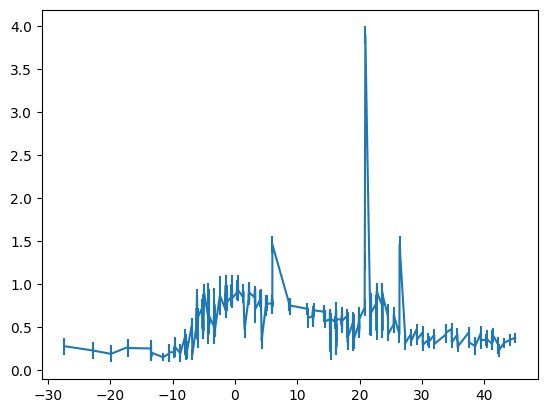

In [193]:
from astropy.table import Table
import pyarrow.feather as feather

# Read the feather file as a pyarrow Table
# Read the feather file as a pyarrow Table and convert to astropy Table
lc_table = feather.read_table("_ts.feather")

# print(lc_table.schema)

def ns_to_days(ns):
    return ns / (1e9 * 60 * 60 * 24)

# Convert each column to a numpy array and print its name and shape
columns = {}
for col_name in ['phase', 'mag', 'mag_error', 'flux', 'flux_error', 'filter', 'zeropoint']:
    arr = np.array(lc_table[col_name])
    print(f"{col_name}: shape {arr.shape}")
    # Replace NaNs with zero if the dtype is float
    if np.issubdtype(arr.dtype, np.floating):
        arr = np.nan_to_num(arr, nan=0.1)
    columns[col_name] = arr

# columns['time'] = columns['phase'] - np.min(columns['phase'])
columns['time'] = columns['phase']

columns['zpsys'] = np.array(['ab'] * len(columns['phase']), dtype=str)

band_name_dict = {'ZTF_r': 'ztfr', 'ZTF_g': 'ztfg', 'ZTF_i': 'ztfi'}

columns['band'] = np.array([band_name_dict[i] for i in columns['filter']], dtype=str)

# remove unit from time and convert to days
# remove unit from time and convert to days, then to float64
# If the dtype is timedelta64[ns], convert to float days
if np.issubdtype(columns['time'].dtype, np.timedelta64):
    columns['time'] = columns['time'].astype('timedelta64[ns]').astype('float64') / (1e9 * 60 * 60 * 24)
columns['time'] = columns['time'].astype(np.float64)

# Remove the 'phase' column
del columns['phase']
del columns['filter']


# Create an astropy Table from these columns
astropy_lc_table = Table(columns)
print(astropy_lc_table)

plt.errorbar(astropy_lc_table['time'], astropy_lc_table['flux'], yerr = astropy_lc_table['flux_error'])

# # lc_table['time'] = lc_table['phase']

# # If you know the redshift, set it here; otherwise, use a guess (e.g., 0.1)
# z_guess = lc_table.meta.get('z', 0.1) if hasattr(lc_table, 'meta') else 0.1

# # Fit as Ia
# try:
#     ia_result, ia_model = fit_ia(z_guess, [lc_table])
#     print("Ia fit result:", ia_result)
# except Exception as e:
#     print("Ia fit failed:", e)

# # Fit as Ibc
# try:
#     ibc_result, ibc_model = fit_ibc(z_guess, [lc_table])
#     print("Ibc fit result:", ibc_result)
# except Exception as e:
#     print("Ibc fit failed:", e)

# # Optional: plot the light curve and fits
# import matplotlib.pyplot as plt
# sncosmo.plot_lc(lc_table, model=ia_model, errors=ia_result.errors if ia_result else None)
# plt.title("SALT2 (Ia) fit")
# plt.show()

# sncosmo.plot_lc(lc_table, model=ibc_model, errors=ibc_result.errors if ibc_result else None)
# plt.title("Arnett (Ibc) fit")
# plt.show()

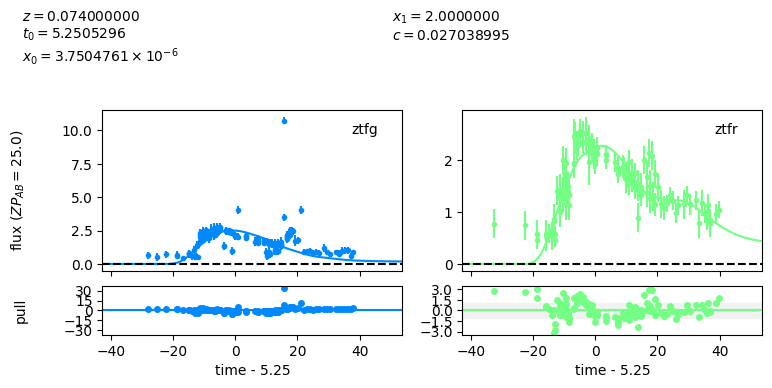

In [194]:
result, fitted_model = fit_ia(0.074, [astropy_lc_table])
sncosmo.plot_lc(astropy_lc_table, model=fitted_model);

ValueError: `y` must contain only finite values.

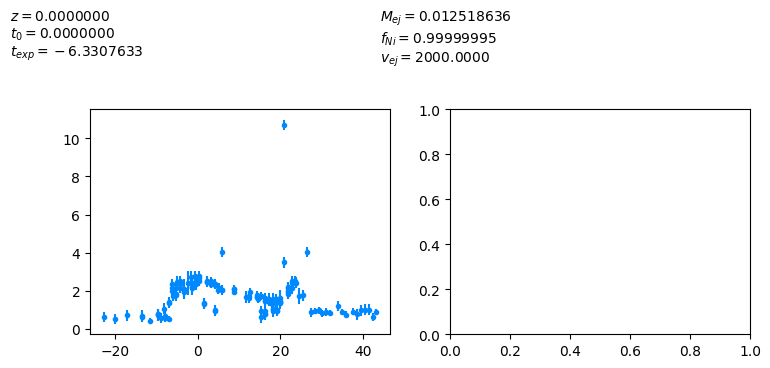

In [195]:
result, fitted_model = fit_ibc(0.074, [astropy_lc_table])
sncosmo.plot_lc(astropy_lc_table, model=fitted_model);

In [179]:
import dill

# Replace with your actual file path
dill_path = "meta.dill copy"

with open(dill_path, "rb") as f:
    obj = dill.load(f)

print(type(obj))
print(obj.keys())

<class 'dict'>
dict_keys(['id', '_ra', '_dec', 'internal_names', 'spec_class', 'redshift', 'max_flux', 'peak_abs_mag', 'meta_attrs'])


In [182]:
obj['redshift'], obj['spec_class'], obj['internal_names']

(0.074, 'SN IIn', {'ZTF19abzfxel'})

In [178]:
lc_table = feather.read_table("_ts.feather")
lc_table.schema

fid: int64
filt_center: double
filt_width: double
filter: string
flux: double
flux_error: double
mag: double
mag_error: double
upper_limit: bool
zeropoint: double
phase: duration[ns]
-- schema metadata --
pandas: '{"index_columns": ["phase"], "column_indexes": [{"name": null, "' + 1470